In [2]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

from shutter_analysis import *

In [3]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [4]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [5]:
hdf_dir = Path("../data")

In [6]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4

In [7]:
fname = "2021_3_12.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        try:
            print(f"{idn:<2} <> {name:<60} : {len(f[name]['readout']['PXIe-5171'])}")
        except:
            print(f"{idn:<2} <> {name:<60} : incomplete")

0  <> 1615578954 scan R0 F1 with P2 F1 near resonance (not scanned yet) : 1
1  <> 1615578990 scan R0 F1 with P2 F1 near resonance (not scanned yet) : 51
2  <> 1615579081 scan R0 F1 with P2 F1 near resonance (not scanned yet) : 321
3  <> 1615579361 scan P2 F1 with R0 F1 on resonance                : 281
4  <> 1615579896 scan P2 F1 with shutter                           : 961
5  <> 1615580527 scan P2 F1 with shutter and J1 J2 microwaves      : 641
6  <> 1615581677 scan P2 F1 with shutter and J1 J2 microwaves      : 1771
7  <> 1615586196 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves : 2001
8  <> 1615586682 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves : 841
9  <> 1615586915 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves with shutter : 1681
10 <> 1615587344 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves with shutter : 1681
11 <> 1615587745 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves with shutter : 841
12 <

In [8]:
slice_flm  = np.s_[:150]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

# Scan P2 F1 with J1$\rightarrow$J2 microwaves
While measuring we discovered the power had dropped to $\approx 32$ mW from 40 mW

In [9]:
dset_name = dset_names[5]
devices = ('SynthHD Pro',)

In [10]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

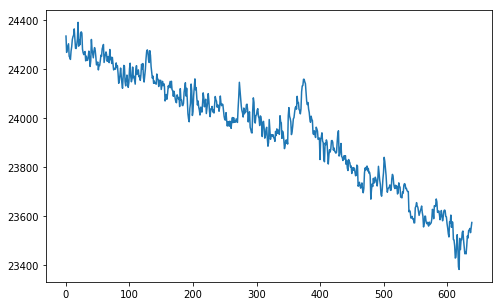

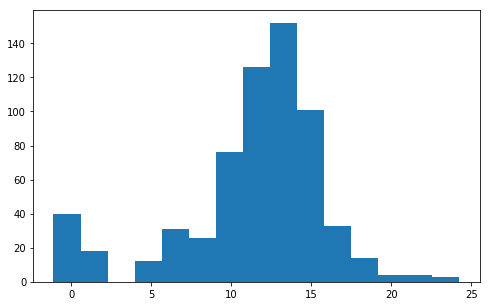

In [11]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [12]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

nbunch = 10

In [13]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [14]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

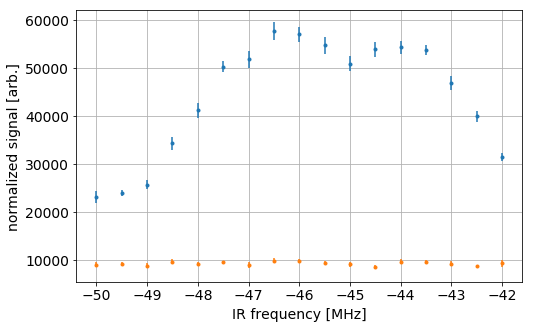

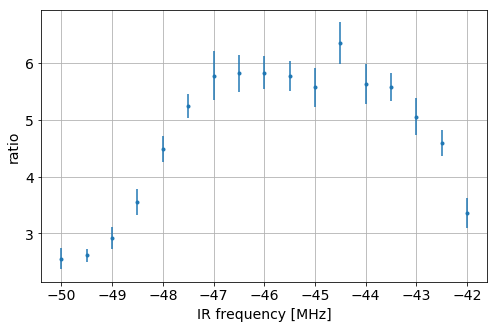

In [15]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Reoptimized to get 40 mW UV on P2 F1 again

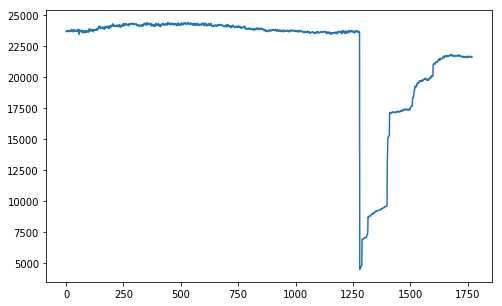

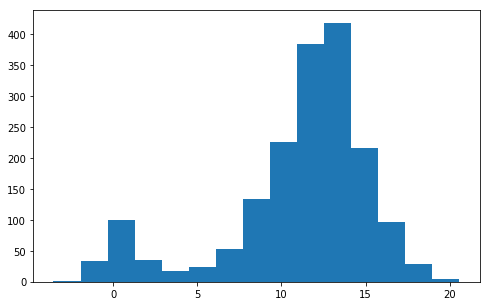

In [16]:
dset_name = dset_names[6]
devices = ('SynthHD Pro',)

scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [17]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

In [18]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [19]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

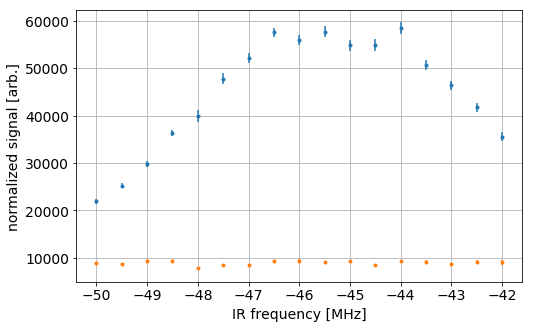

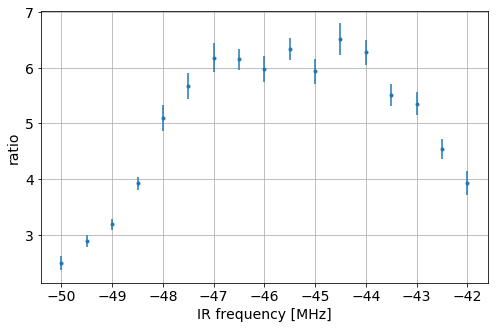

In [20]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Scan J2$\rightarrow$J3 microwaves with RC on (P2 F1 40 mW) R0 F1 DET (60 mW) and J1$\rightarrow$J2 microwaves

In [21]:
devices = ('SynthHD Pro',)

scan_parameter = 'SynthHD Pro SetFrequencyCHBGUI'

yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


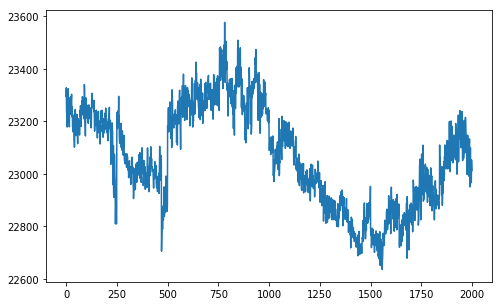

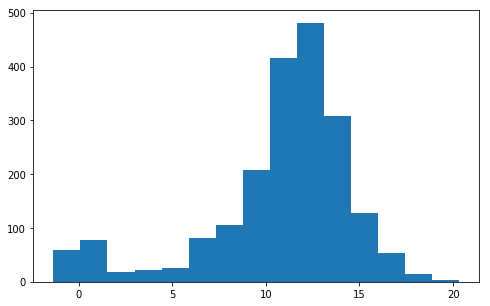

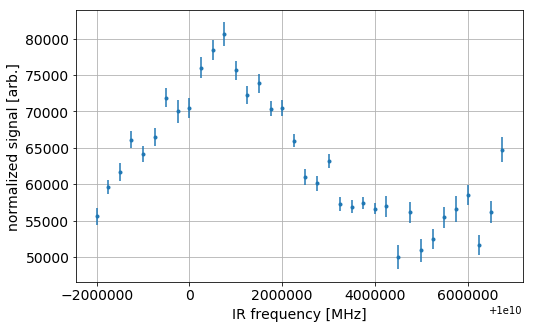

In [22]:
dset_name = dset_names[7]

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)


bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanmean(x), bins = bins)
err, _, _ = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', label = 'RC on')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

The next dataset (`1615586682 find J2 J3 microwaves with R0 F1 and P2 F1 and J1J2 microwaves`) is a narrow scan around what is supposed to be the center, but not wide enough to see the resonance.

# Scan J2$\rightarrow$J3 microwaves with RC on (P2 F1 40 mW) R0 F1 DET (60 mW) and J1$\rightarrow$J2 microwaves
Using shutter

Microwave settings : J1->J2 -17.0 dBm FNG, J2->J3 -9.4 dBm FNG


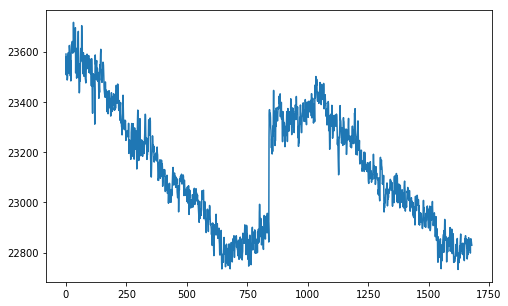

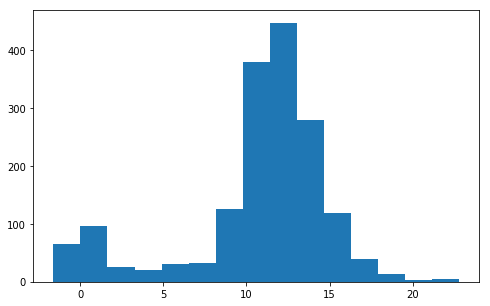

In [23]:
dset_name = dset_names[9]
devices = ('SynthHD Pro',)

scan_parameter = 'SynthHD Pro SetFrequencyCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.1f} dBm FNG, J2->J3 {dat['CHB power'].mean():.1f} dBm FNG")

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [24]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

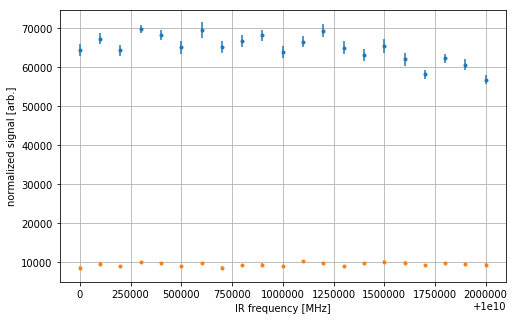

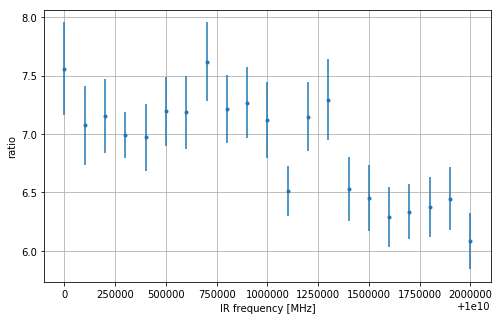

In [25]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

# set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

# set_fontsize(ax, 14)

Microwave settings : J1->J2 -17.0 dBm FNG, J2->J3 -7.4 dBm FNG


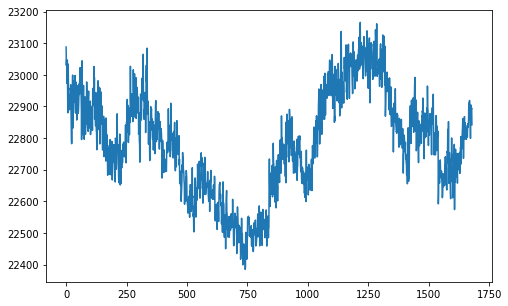

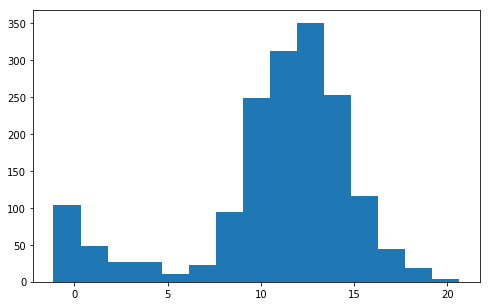

In [26]:
dset_name = dset_names[10]
devices = ('SynthHD Pro',)

scan_parameter = 'SynthHD Pro SetFrequencyCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)


dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.1f} dBm FNG, J2->J3 {dat['CHB power'].mean():.1f} dBm FNG")

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [27]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

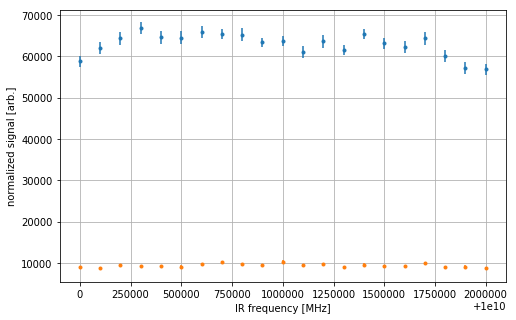

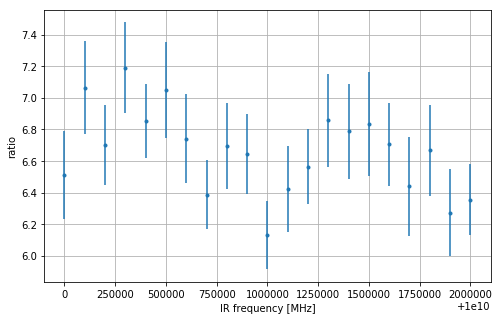

In [28]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

# set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

# set_fontsize(ax, 14)

Microwave settings : J1->J2 -17.0 dBm FNG, J2->J3 -11.1 dBm FNG


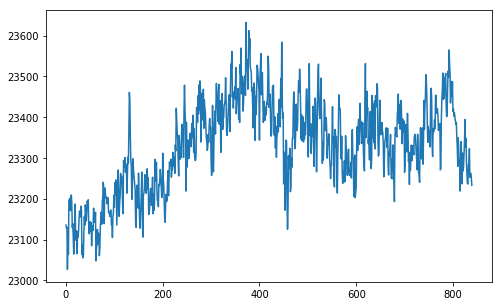

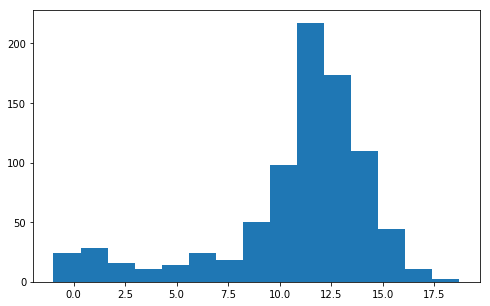

In [29]:
dset_name = dset_names[11]
devices = ('SynthHD Pro',)

scan_parameter = 'SynthHD Pro SetFrequencyCHBGUI'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)


dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.1f} dBm FNG, J2->J3 {dat['CHB power'].mean():.1f} dBm FNG")

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [30]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

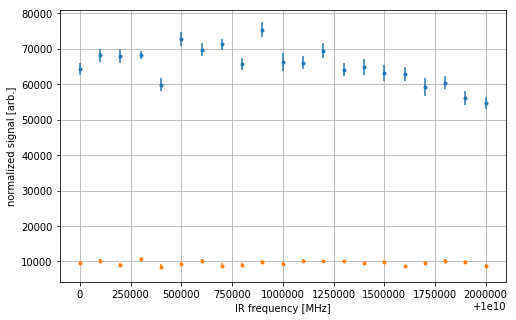

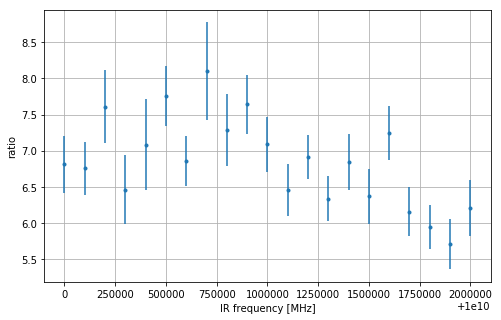

In [31]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

# set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

# set_fontsize(ax, 14)

# Scan P2 F1 (40 mW) with R3 F4 DET (60 mW) and J2$\rightarrow$J3 microwaves on

R0 F1 and J2$\rightarrow$J3 not precisely on resonance for this measurement

In [32]:
devices = ('SynthHD Pro',)

scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

Microwave settings : J1->J2 -31.50 dBm FNG, J2->J3 -11.10 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0010 GHz
Microwave settings : J1->J2 False, J2->J3 True


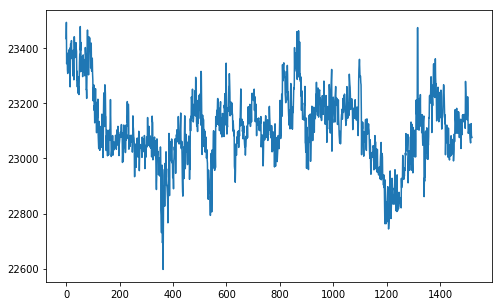

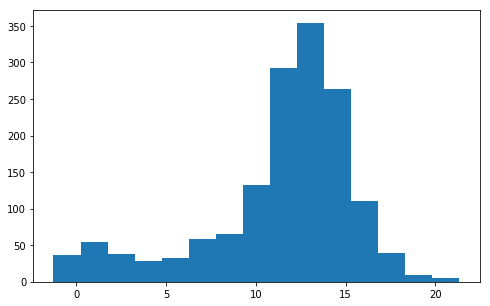

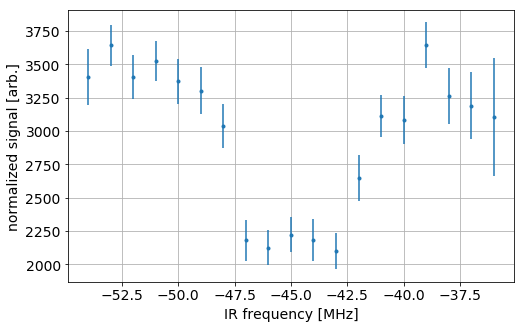

In [33]:
dset_name = dset_names[17]

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.4f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.4f} GHz")
print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")


fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)


bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanmean(x), bins = bins)
err, _, _ = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)

bin_means = bin_edges[:-1]+bin_width/2

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, stat, yerr = err, fmt = '.', label = 'RC on')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

Depletion of ~60%

# Scan J2$\rightarrow$J3 microwaves with RC on (P2 F1 40 mW) R3 F4 DET (60 mW)

Various microwave powers

In [34]:
devices = ('SynthHD Pro',)

scan_parameter = 'SynthHD Pro SetFrequencyCHBGUI'

yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

Microwave settings : J1->J2 -31.50 dBm FNG, J2->J3 -11.10 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0014 GHz
Microwave settings : J1->J2 False, J2->J3 True
Depletion ~31.4%
Resonance ~10001250000.0
Microwave settings : J1->J2 -31.50 dBm FNG, J2->J3 -9.36 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0015 GHz
Microwave settings : J1->J2 False, J2->J3 True
Depletion ~32.2%
Resonance ~10000750000.0
Microwave settings : J1->J2 -31.50 dBm FNG, J2->J3 -7.86 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0012 GHz
Microwave settings : J1->J2 False, J2->J3 True
Depletion ~29.8%
Resonance ~10000000000.0


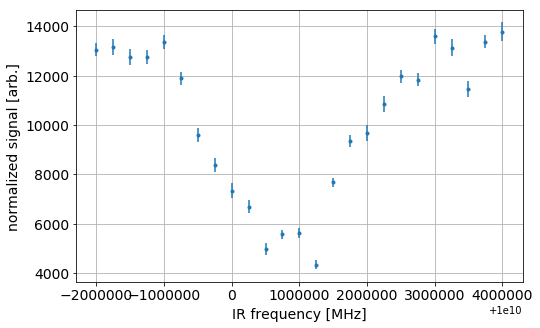

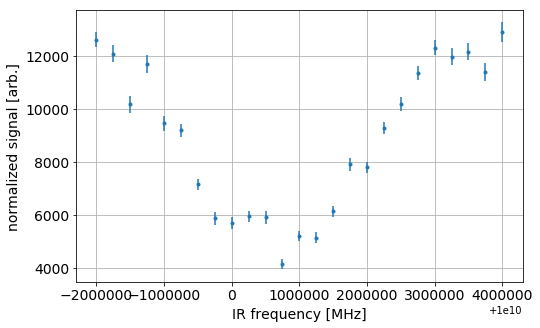

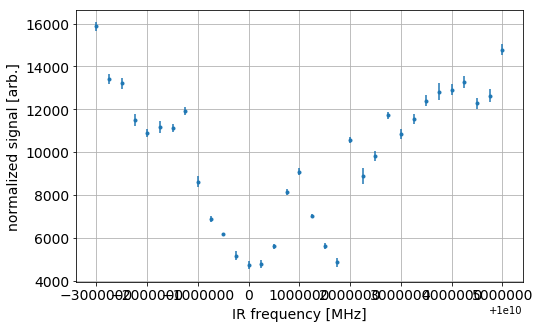

In [35]:
for dset_name in dset_names[18:21]:
    pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

    yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
    pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
    pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
    pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
    shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
    pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

    scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

    norm_data = -pd_data/pdn_data

    dat = data_devices['SynthHD Pro']
    print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
    print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.4f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.4f} GHz")
    print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")


#     fig, ax = plt.subplots(figsize = (8,5))
#     ax.plot(pdn_data.mean(axis = 1))

#     fig, ax = plt.subplots(figsize = (8,5))
#     ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
#             bins = 15);

    pmt_data_norm = pmt_data.copy()
    norm_data_norm = norm_data.copy()

    mask_yag = yag_data.max(axis = 1) < yag_cutoff
    mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
    mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
    mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

    mask = mask_yag | mask_pdn | mask_abs | mask_fl

    norm_data_norm[mask] = np.nan
    norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

    pmt_data_norm[mask] = np.nan
    pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

    fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
    absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)


    bin_width = np.diff(np.unique(scan_parameters)).min()
    bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

    stat, bin_edges, bin_number = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters, fluorescence_integral/absorption_integral, lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)

    bin_means = bin_edges[:-1]+bin_width/2

    fig, ax = plt.subplots(figsize = (8,5))
    ax.errorbar(bin_means, stat, yerr = err, fmt = '.', label = 'RC on')

    ax.set_xlabel('IR frequency [MHz]')
    ax.set_ylabel('normalized signal [arb.]')

    ax.grid(True)

    set_fontsize(ax, 14)
    
    print(f'Depletion ~{stat.min()/stat.max() * 100:.1f}%')
    print(f'Resonance ~{bin_means[np.argmin(stat)]}')
          
    print("="*50)

Depletion figures here are not accurate; larger microwave scan range required to get population without effect of microwaves

# Scan P2 F1 (40 mW) with R0 F1 DET (60 mW) and J2$\rightarrow$J3 microwaves on

Microwave settings : J1->J2 -31.50 dBm FNG, J2->J3 -9.36 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0008 GHz
Microwave settings : J1->J2 False, J2->J3 True


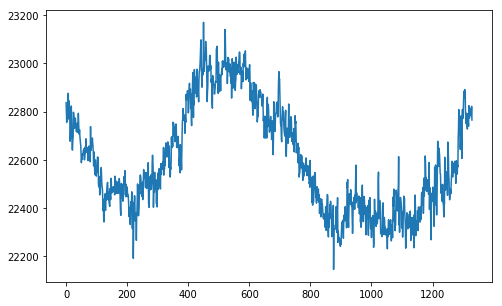

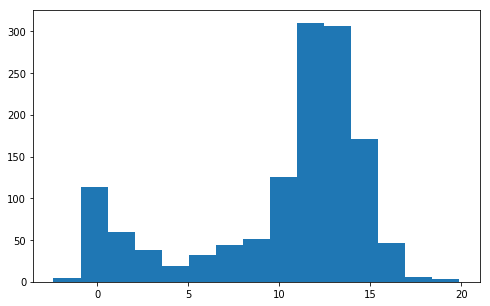

In [36]:
dset_name = dset_names[22]
devices = ('SynthHD Pro',)

scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.4f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.4f} GHz")
print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [37]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

In [38]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [39]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

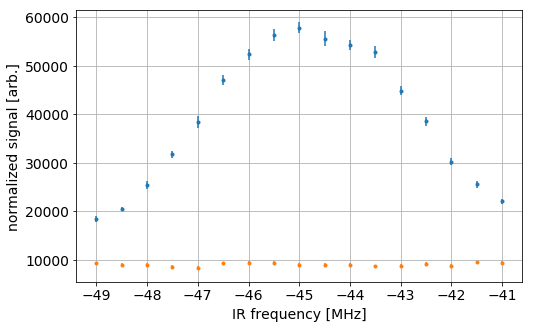

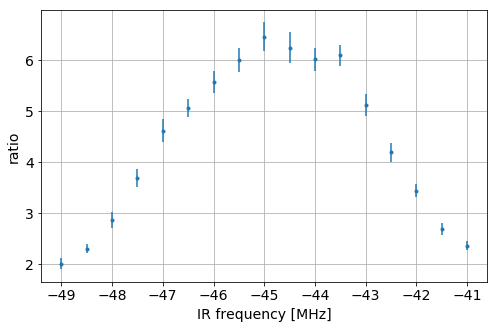

In [40]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Scan P2 F1 (40 mW) with R0 F1 DET (60 mW) and J2$\rightarrow$J3 + J1$\rightarrow$J3 microwaves on

Microwave settings : J1->J2 -17.00 dBm FNG, J2->J3 -9.36 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0008 GHz
Microwave settings : J1->J2 True, J2->J3 True


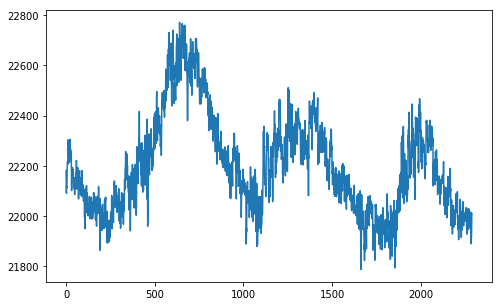

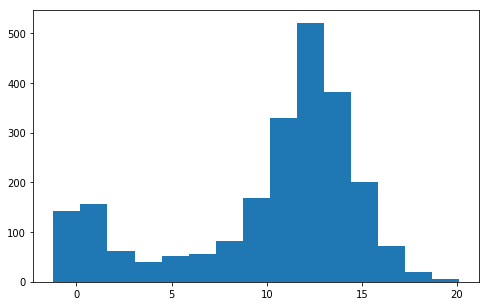

In [41]:
dset_name = dset_names[23]
devices = ('SynthHD Pro',)

scan_parameter = 'Laser Lock 1 SetLockPointSeed1'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.4f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.4f} GHz")
print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [42]:
yag_cutoff = 250
ptn_cutoff = 22000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

In [43]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [44]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

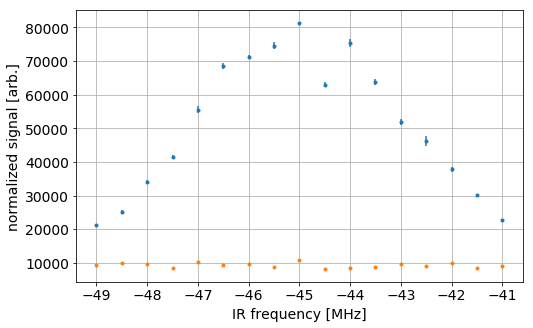

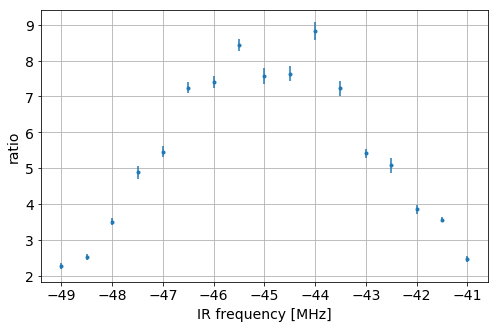

In [45]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

# Scan polarization switching frequencies
### With P2 F1 (40 mW) with R0 F1 DET (60 mW) and J2$\rightarrow$J3 + J1$\rightarrow$J3 microwaves on

Microwave settings : J1->J2 -17.00 dBm FNG, J2->J3 -9.36 dBm FNG
Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0008 GHz
Microwave settings : J1->J2 True, J2->J3 True


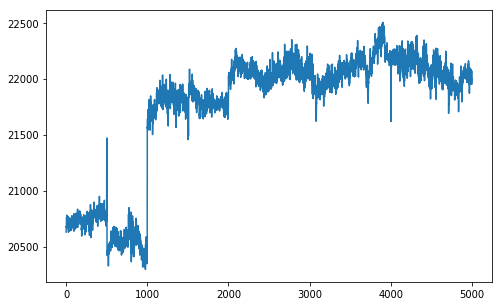

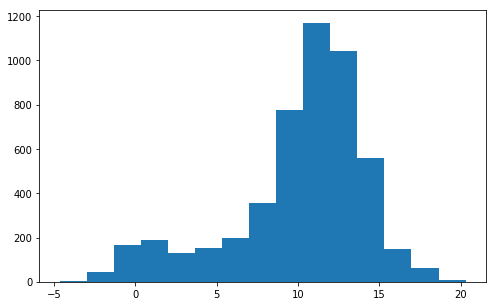

In [64]:
dset_name = dset_names[25]
devices = ('SynthHD Pro',)

scan_parameter = 'BK4063 SetChannel1Frequency'

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

dat = data_devices['SynthHD Pro']
print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.4f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.4f} GHz")
print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [65]:
yag_cutoff = 250
ptn_cutoff = 20000
abs_cutoff = 7.5
fl_cutoff = -5000
shutter_cutoff = 10000

In [66]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [67]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


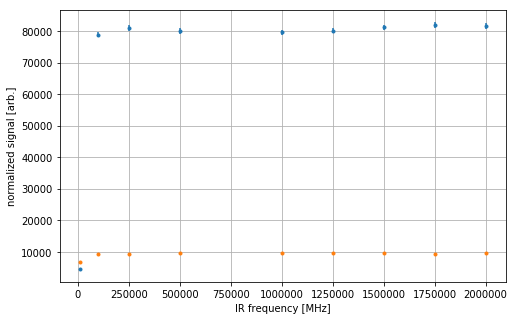

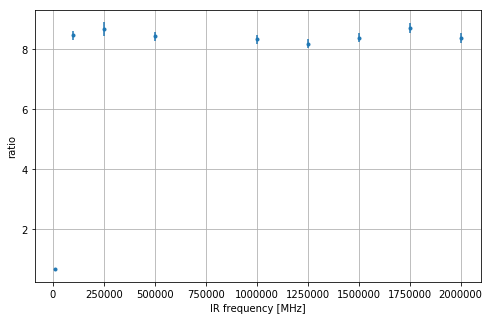

In [68]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

# set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

# set_fontsize(ax, 14)

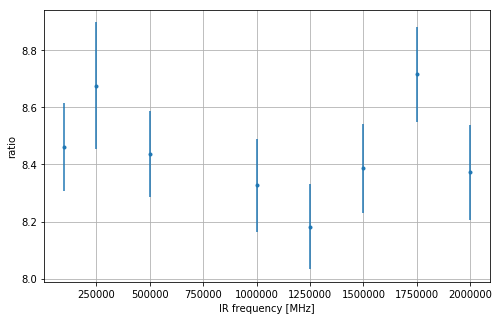

In [77]:
m = np.s_[2:]
ratio, err = ratio_with_error(results[0][0][m], results[1][0][m], results[0][1][m], results[1][1][m])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means[m], ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

# set_fontsize(ax, 14)

# Scan microwave powers
### With P2 F1 (40 mW) with R0 F1 DET (60 mW) and J2$\rightarrow$J3 + J1$\rightarrow$J3 microwaves on

Microwave settings : J1->J2 13.3345 GHz, J2->J3 10.0008 GHz
Microwave settings : J1->J2 True, J2->J3 True


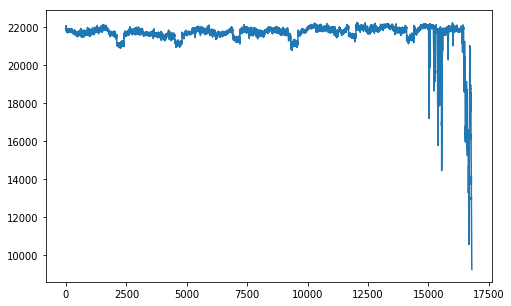

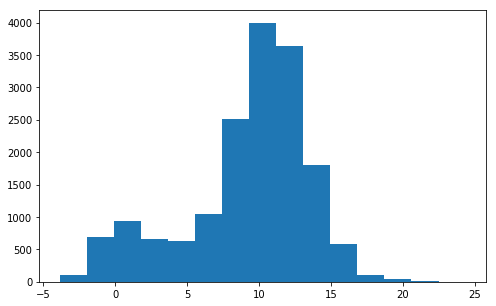

In [51]:
dset_name = dset_names[26]
devices = ('SynthHD Pro',)

pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

dat = data_devices['SynthHD Pro']
# print(f"Microwave settings : J1->J2 {dat['CHA power'].mean():.2f} dBm FNG, J2->J3 {dat['CHB power'].mean():.2f} dBm FNG")
print(f"Microwave settings : J1->J2 {dat['CHA Frequency'].mean()/1e9:.5f} GHz, J2->J3 {dat['CHB Frequency'].mean()/1e9:.5f} GHz")
print(f"Microwave settings : J1->J2 {dat['CHA status'][-1]}, J2->J3 {dat['CHB status'][-1]}")

norm_data = -pd_data/pdn_data

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(pdn_data.mean(axis = 1))

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]), 
        bins = 15);

In [52]:
yag_cutoff = 250
ptn_cutoff = 20000
abs_cutoff = 5
fl_cutoff = -5000
shutter_cutoff = 10000

In [53]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [54]:
power_A = np.array([pxie_attrs[i]['SynthHD Pro SetPowerCHAGUI'] for i in range(1, len(pxie)+1)])
power_B = np.array([pxie_attrs[i]['SynthHD Pro SetPowerCHBGUI'] for i in range(1, len(pxie)+1)])

In [55]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

In [56]:
power_Au = np.unique(power_A)
power_Bu = np.unique(power_B)

results = []
for m_shutter in [mask_sh_open, mask_sh_closed]:
    signal = np.zeros([power_Au.size, power_Bu.size])
    error = signal.copy()
    n_shots = signal.copy()
    for idA, pA in enumerate(power_Au):
        for idB, pB in enumerate(power_Bu):
            mA = power_A == pA
            mB = power_B == pB
            m = mA & mB & m_shutter
            dat = fluorescence_integral[m]/absorption_integral[m]
            signal[idA, idB] = np.nanmean(dat)
            error[idA, idB] = np.nanstd(dat)/(len(dat)-1)
            n_shots[idA, idB] = np.sum(~np.isnan(fluorescence_integral[m]))
    results.append((signal, error, n_shots))

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


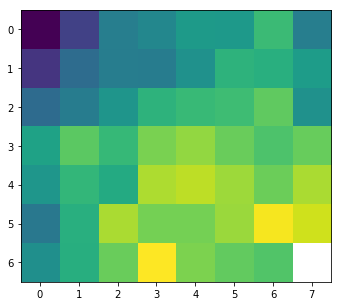

In [57]:
fig, ax = plt.subplots(figsize = (8,5))
ax.imshow(results[0][0]/results[1][0])

In [58]:
r = []
for m_shutter in [mask_sh_open, mask_sh_closed]:
    signal = []
    error = []
    A = []
    B = []
    for idA, pA in enumerate(power_Au):
        for idB, pB in enumerate(power_Bu):
            mA = power_A == pA
            mB = power_B == pB
            m = mA & mB & m_shutter
            dat = fluorescence_integral[m]/absorption_integral[m]
            signal.append(np.nanmean(dat))
            error.append(np.nanstd(dat)/(len(dat)-1))
            A.append(pA)
            B.append(pB)
    r.append((A, B, signal, error))
r = np.array(r)

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\CeNTREX\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


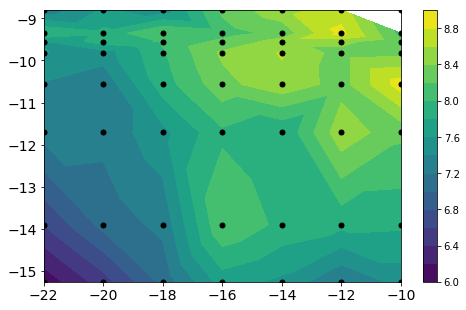

In [59]:
d = (r[0]/r[1])[2]
x = r[0][0,:]
y = r[0][1,:]

fig, ax = plt.subplots(figsize = (8,5))
c = ax.tricontourf(x[:-1],y[:-1], d[:-1], 15)
ax.plot(x,y, 'k.', ms = 10)
fig.colorbar(c)

set_fontsize(ax, 14)

In [60]:
# power conversion
conv_26 = {-22: 0, -20:10, -18: 16, -16: 23, -14: 26, -12: 27, -10: 30}
conv_40 = {-15.26: 0, -13.9: 5, -11.71: 10, -10.57: 15, -9.82: 20, -9.55: 22, -9.35: 24, -8.8: 28}

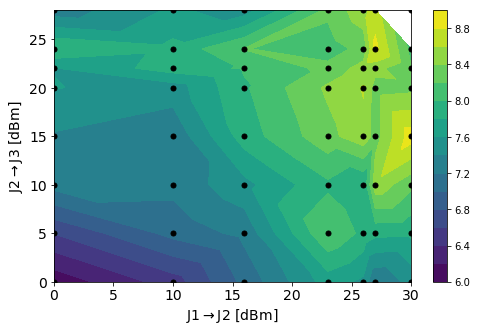

In [61]:
d = (r[0]/r[1])[2]
x = [conv_26[val] for val in r[0][0,:]]
y = [conv_40[val] for val in r[0][1,:]]

fig, ax = plt.subplots(figsize = (8,5))
c = ax.tricontourf(x[:-1],y[:-1], d[:-1], 15)
ax.plot(x,y, 'k.', ms = 10)
fig.colorbar(c)

ax.set_ylabel(r'J2$\rightarrow$J3 [dBm]')
ax.set_xlabel(r'J1$\rightarrow$J2 [dBm]')

set_fontsize(ax, 14)

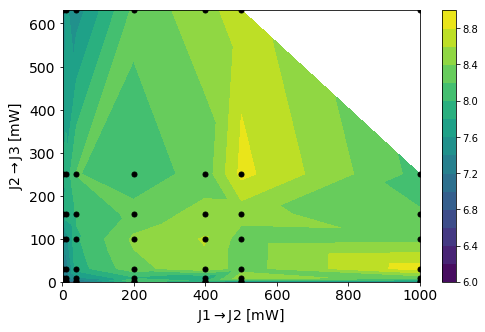

In [62]:
d = (r[0]/r[1])[2]
x = np.array([conv_26[val] for val in r[0][0,:]])
y = np.array([conv_40[val] for val in r[0][1,:]])
x = 10**(x/10)
y = 10**(y/10)


fig, ax = plt.subplots(figsize = (8,5))
c = ax.tricontourf(x[:-1],y[:-1], d[:-1], 15)
ax.plot(x,y, 'k.', ms = 10)
fig.colorbar(c)
ax.set_ylabel(r'J2$\rightarrow$J3 [mW]')
ax.set_xlabel(r'J1$\rightarrow$J2 [mW]')

set_fontsize(ax, 14)